In [1]:
%pylab inline

import math
import datetime
import pandas as pd
from pprint import pprint

Populating the interactive namespace from numpy and matplotlib


In [2]:
from IPython.display import Image

In [3]:
import ee
ee.Initialize()
import rendvi
from rendvi import eeCollections

In [4]:
# time information to handle image collection
iniYear = 2005
endYear = 2010

today = ee.Date(datetime.datetime.now().strftime('%Y-%m-%d')).advance(-7,'day')

# convert start and end dates to EE date objects
eeIni = ee.Date.fromYMD(iniYear,1,1,)
eeEnd = ee.Date.fromYMD(endYear,12,31)

# make list of years for loop processing
years = ee.List.sequence(iniYear,endYear)

In [5]:
mod = eeCollections.MOD09GQ['imageCollection'].filterDate(eeIni,eeEnd)
mod1km = eeCollections.MOD09GA['imageCollection'].filterDate(eeIni,eeEnd)

In [6]:
masked = rendvi.Masking.applyModis(mod,mod1km)
withNdvi = rendvi.Utils.addNDBand(masked,
                                  b1=eeCollections.MOD09GQ['nir'],
                                  b2=eeCollections.MOD09GQ['red'],
                                  outName='ndvi')

In [7]:
full = rendvi.Rendvi(withNdvi,'ndvi')
dekads = full.getDekadImages(years,includeQa=False)

In [8]:
from rendvi import forecast

In [9]:
fm = forecast.Harmonics()

In [10]:
detrended = fm.detrend(full)

In [11]:
geo = ee.Geometry.Point([36.8412,-1.3584]) # Nairobi

df = detrended.getTimeSeries(geo,250)

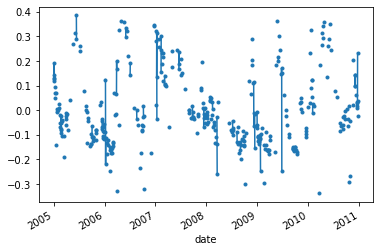

In [12]:
df.ndvi.plot(marker='o',markersize=3)

In [13]:
detrended = fm._prepInputs(detrended)

In [14]:
fm.fit(detrended)

In [15]:
harmonicTrend = fm.predict(detrended)

In [16]:
pred = harmonicTrend.getTimeSeries(geo,250)

TypeError: no numeric data to plot

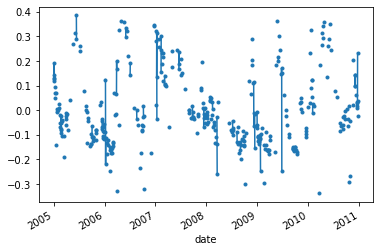

In [20]:
ax = df.ndvi.plot(marker='o',markersize=3)
pred.predicted.plot(ax=ax,marker='x',markersize=3)

In [17]:
harmonicCoefs = fm.harmonicCoefficients

# Compute phase and amplitude.
# Scale to [0, 1] from radians
phase = harmonicCoefs.select('sin')\
    .atan2(harmonicCoefs.select('cos'))\
    .unitScale(-math.pi, math.pi)
    
amplitude = harmonicCoefs.select('sin')\
    .hypot(harmonicCoefs.select('cos'))\
    .multiply(5) # Add a scale factor for visualization.

# Compute the mean NDVI.
meanNdvi= full.imageCollection.select('ndvi').mean();

# Use the HSV to RGB transform to display phase and amplitude.
rgb = ee.Image.cat([
  phase,      # hue
  amplitude,  # saturation (difference from white)
  meanNdvi    # value (difference from black)
]).hsvToRgb();


In [30]:
kenya = ee.Geometry.Rectangle([34, -2, 38, 2])
thumbnail = ee.Image(rgb).getThumbUrl({'min':0,'max':1,'region':kenya,'format':'png','dimensions':512})
# display result
Image(url = thumbnail)

In [19]:
exportRegion = ee.Geometry.Rectangle([33.8679, -4.816276, 41.97685, 4.629931])
rendvi.exportImage(harmonicCoefs, exportRegion, 'users/kelmarkert/harmonics', description="harmonics_export", scale=250, crs='EPSG:4326')